In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Install required packages
!pip install healpy astropy matplotlib numpy

# Verify the data file exists
fits_path = "/content/drive/MyDrive/PlanckDeep/COM_CMB_IQU-smica_2048_R3.00_full.fits"
if os.path.exists(fits_path):
    print(f"✓ Data file found: {fits_path}")
    file_size = os.path.getsize(fits_path) / (1024**3)  # Size in GB
    print(f"File size: {file_size:.2f} GB")
else:
    print(f"✗ Data file not found: {fits_path}")
    print("Please check the path and make sure the file is uploaded to Google Drive")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 96.2 MB/s eta 0:00:00
✓ Data file found: /content/drive/MyDrive/PlanckDeep/COM_CMB_IQU-smica_2048_R3.00_full.fits
File size: 1.88 GB


Loading CMB temperature map...
Map loaded successfully!
Map shape: (50331648,)
Map statistics:
  Mean: 0.000000 K
  Std: 0.000108 K
  Min: -0.005755 K
  Max: 0.007899 K


<Figure size 1200x600 with 0 Axes>

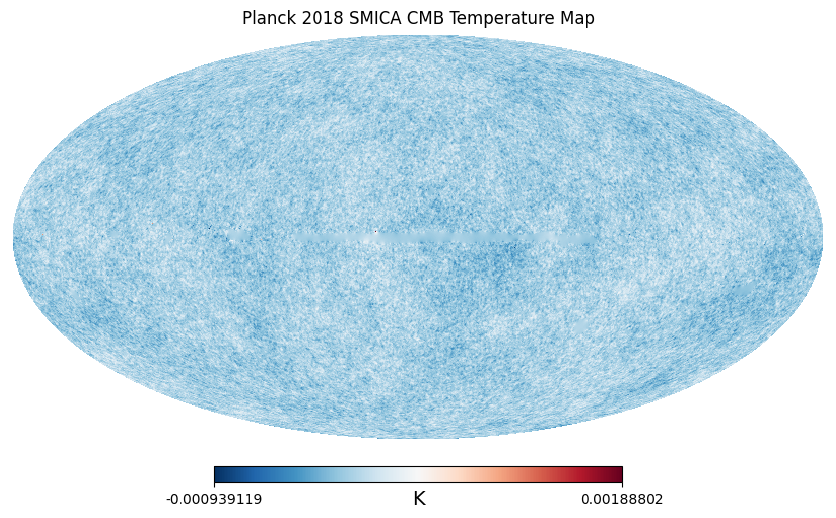

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the CMB temperature map
print("Loading CMB temperature map...")
fits_path = "/content/drive/MyDrive/PlanckDeep/COM_CMB_IQU-smica_2048_R3.00_full.fits"
cmb_map = hp.read_map(fits_path, field=0)  # field=0 is temperature

print(f"Map loaded successfully!")
print(f"Map shape: {cmb_map.shape}")
print(f"Map statistics:")
print(f"  Mean: {np.mean(cmb_map):.6f} K")
print(f"  Std: {np.std(cmb_map):.6f} K")
print(f"  Min: {np.min(cmb_map):.6f} K")
print(f"  Max: {np.max(cmb_map):.6f} K")

# Quick visualization of the full sky
plt.figure(figsize=(12, 6))
hp.mollview(cmb_map, title="Planck 2018 SMICA CMB Temperature Map", unit="K", cmap='RdBu_r')
plt.show()


In [ ]:
def enhanced_extract_patches(hmap, patch_size=128, num_patches=5000,
                           avoid_galactic_plane=True, galactic_lat_threshold=20,
                           seed=42):
    """
    Enhanced patch extraction with better sampling strategy
    """
    np.random.seed(seed)  # For reproducibility

    patches = []
    coordinates = []
    galactic_flags = []

    attempts = 0
    max_attempts = num_patches * 10  # Prevent infinite loops

    print(f"Extracting {num_patches} patches of size {patch_size}x{patch_size}...")

    while len(patches) < num_patches and attempts < max_attempts:
        attempts += 1

        if attempts % 1000 == 0:
            print(f"  Progress: {len(patches)}/{num_patches} patches extracted ({attempts} attempts)")

        # Generate random coordinates
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)

        # Check galactic latitude if avoiding galactic plane
        if avoid_galactic_plane:
            # Convert to galactic coordinates
            try:
                galactic_coords = hp.Rotator(coord=['C', 'G'])(theta, phi)
                galactic_lat = np.pi/2 - galactic_coords[0]
                galactic_lat_deg = abs(np.degrees(galactic_lat))

                if galactic_lat_deg < galactic_lat_threshold:
                    continue  # Skip this patch
            except:
                continue

        try:
            # Extract patch using gnomonic projection
            patch = hp.gnomview(hmap, rot=(np.degrees(phi), np.degrees(theta)),
                              xsize=patch_size, return_projected_map=True,
                              no_plot=True)

            # Check for valid patch (not all NaN/masked)
            if patch is not None and not np.isnan(patch).all() and patch.size == patch_size * patch_size:
                # Additional quality checks
                nan_fraction = np.isnan(patch).sum() / patch.size
                if nan_fraction < 0.1:  # Less than 10% NaN pixels
                    patches.append(patch)
                    coordinates.append((theta, phi))

                    # Flag for galactic plane proximity
                    try:
                        galactic_coords = hp.Rotator(coord=['C', 'G'])(theta, phi)
                        galactic_lat = np.pi/2 - galactic_coords[0]
                        galactic_lat_deg = abs(np.degrees(galactic_lat))
                        galactic_flags.append(galactic_lat_deg < galactic_lat_threshold)
                    except:
                        galactic_flags.append(False)

        except Exception as e:
            continue

    print(f"Successfully extracted {len(patches)} patches in {attempts} attempts")

    return np.array(patches), np.array(coordinates), np.array(galactic_flags)

def preprocess_patches(patches, remove_monopole=True, normalize=True):
    """
    Preprocess CMB patches for ML training
    """
    processed_patches = patches.copy()

    if remove_monopole:
        # Remove the mean from each patch (removes monopole)
        for i in range(len(processed_patches)):
            processed_patches[i] -= np.mean(processed_patches[i])

    if normalize:
        # Normalize each patch to have unit variance
        for i in range(len(processed_patches)):
            std = np.std(processed_patches[i])
            if std > 0:
                processed_patches[i] /= std

    return processed_patches

def create_meaningful_labels(patches, coordinates, galactic_flags):
    """
    Create multiple types of meaningful labels for classification
    """
    # 1. Temperature-based labels (hot vs cold regions)
    avg_temps = np.mean(patches, axis=(1, 2))
    temp_threshold = np.median(avg_temps)
    temp_labels = (avg_temps > temp_threshold).astype(int)

    # 2. Variance-based labels (smooth vs structured regions)
    variances = np.var(patches, axis=(1, 2))
    variance_threshold = np.median(variances)
    variance_labels = (variances > variance_threshold).astype(int)

    # 3. Galactic plane labels
    galactic_labels = galactic_flags.astype(int)

    # 4. Power spectrum based labels
    power_labels = []
    power_values = []

    for patch in patches:
        # Compute 2D FFT and total power
        fft_patch = np.fft.fft2(patch)
        power = np.sum(np.abs(fft_patch)**2)
        power_values.append(power)

    power_threshold = np.median(power_values)
    power_labels = np.array([(p > power_threshold) for p in power_values]).astype(int)

    return {
        'temperature': temp_labels,
        'variance': variance_labels,
        'galactic': galactic_labels,
        'power': power_labels
    }

=== CMB Patch Extraction Pipeline ===
Extracting 5000 patches of size 128x128...
  Progress: 666/5000 patches extracted (1000 attempts)
  Progress: 1331/5000 patches extracted (2000 attempts)
  Progress: 2001/5000 patches extracted (3000 attempts)
  Progress: 2676/5000 patches extracted (4000 attempts)
  Progress: 3346/5000 patches extracted (5000 attempts)
  Progress: 4015/5000 patches extracted (6000 attempts)
  Progress: 4676/5000 patches extracted (7000 attempts)
Successfully extracted 5000 patches in 7489 attempts

Extracted patches shape: (5000, 128, 128)
Coordinates shape: (5000, 2)
Galactic flags shape: (5000,)

Preprocessing patches...
Creating meaningful labels...

Label Statistics:
  Temperature labels: {np.int64(0): np.int64(3332), np.int64(1): np.int64(1668)}
  Variance labels: {np.int64(0): np.int64(4410), np.int64(1): np.int64(590)}
  Galactic labels: {np.int64(0): np.int64(5000)}
  Power labels: {np.int64(0): np.int64(3216), np.int64(1): np.int64(1784)}

Visualizing sam

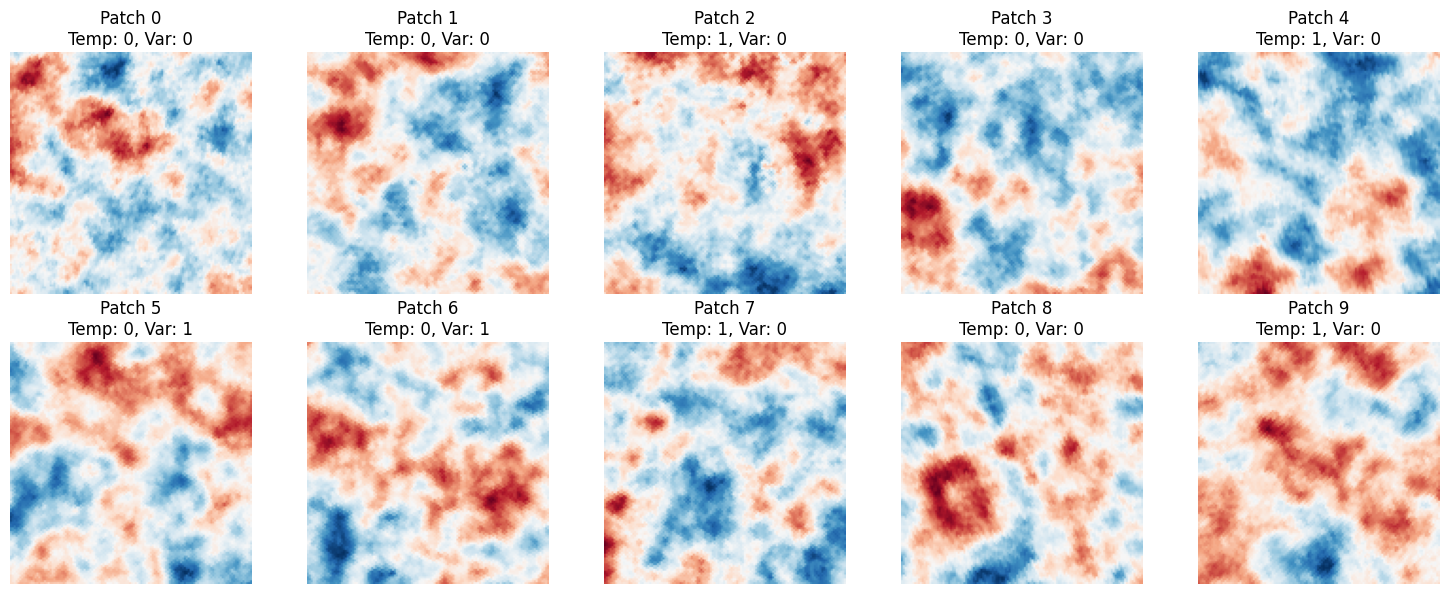

In [ ]:
print("=== CMB Patch Extraction Pipeline ===")

# Extract patches with enhanced method
patches, coordinates, galactic_flags = enhanced_extract_patches(
    cmb_map,
    patch_size=128,  # Larger patches for better feature extraction
    num_patches=5000,  # More patches for better training
    avoid_galactic_plane=True,
    galactic_lat_threshold=20
)

print(f"\nExtracted patches shape: {patches.shape}")
print(f"Coordinates shape: {coordinates.shape}")
print(f"Galactic flags shape: {galactic_flags.shape}")

# Preprocess patches
print("\nPreprocessing patches...")
processed_patches = preprocess_patches(patches, remove_monopole=True, normalize=True)

# Create meaningful labels
print("Creating meaningful labels...")
labels_dict = create_meaningful_labels(processed_patches, coordinates, galactic_flags)

# Print label statistics
print("\nLabel Statistics:")
for label_type, labels in labels_dict.items():
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {label_type.capitalize()} labels: {dict(zip(unique, counts))}")

# Visualize some sample patches
print("\nVisualizing sample patches...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(processed_patches[i], cmap='RdBu_r')
    axes[row, col].set_title(f'Patch {i}\nTemp: {labels_dict["temperature"][i]}, Var: {labels_dict["variance"][i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import os

# Create output directory if it doesn't exist
output_dir = "/content/drive/MyDrive/PlanckDeep/processed_data/"
os.makedirs(output_dir, exist_ok=True)

print("Saving processed data to Google Drive...")

# Save patches and coordinates
np.save(f"{output_dir}/cmb_patches_enhanced.npy", processed_patches)
np.save(f"{output_dir}/cmb_coordinates.npy", coordinates)

# Save all label types
for label_type, labels in labels_dict.items():
    np.save(f"{output_dir}/cmb_{label_type}_labels.npy", labels)

print("Data saved successfully!")
print(f"Output directory: {output_dir}")
print("Files created:")
print(f"  - cmb_patches_enhanced.npy: {processed_patches.shape} ({processed_patches.nbytes / (1024**2):.1f} MB)")
print(f"  - cmb_coordinates.npy: {coordinates.shape}")

for label_type, labels in labels_dict.items():
    print(f"  - cmb_{label_type}_labels.npy: {labels.shape}")

# Verify file sizes
total_size = 0
for filename in os.listdir(output_dir):
    if filename.endswith('.npy'):
        filepath = os.path.join(output_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024**2)
        total_size += size_mb
        print(f"    {filename}: {size_mb:.1f} MB")

print(f"\nTotal data size: {total_size:.1f} MB")
print("\n✓ All data successfully saved to Google Drive!")
print("You can now download these files and use them for local training.")


Saving processed data to Google Drive...
Data saved successfully!
Output directory: /content/drive/MyDrive/PlanckDeep/processed_data/
Files created:
  - cmb_patches_enhanced.npy: (5000, 128, 128) (625.0 MB)
  - cmb_coordinates.npy: (5000, 2)
  - cmb_temperature_labels.npy: (5000,)
  - cmb_variance_labels.npy: (5000,)
  - cmb_galactic_labels.npy: (5000,)
  - cmb_power_labels.npy: (5000,)
    cmb_patches_enhanced.npy: 625.0 MB
    cmb_coordinates.npy: 0.1 MB
    cmb_temperature_labels.npy: 0.0 MB
    cmb_variance_labels.npy: 0.0 MB
    cmb_galactic_labels.npy: 0.0 MB
    cmb_power_labels.npy: 0.0 MB

Total data size: 625.2 MB

✓ All data successfully saved to Google Drive!
You can now download these files and use them for local training.
